# Predicting Qualcomm Stock Prices Using Deep Learning Models

## Introduction

This project aims to predict Qualcomm's stock prices using advanced deep learning models, including LSTM (Long Short-Term Memory), GRU (Gated Recurrent Unit), and a hybrid CNN-LSTM model. The goal is to analyze the historical stock data, engineer meaningful features, and evaluate the performance of different models in forecasting future stock prices. The notebook is structured as follows:

1. Data Loading and Preprocessing
2. Exploratory Data Analysis (EDA)
3. Feature Engineering
4. Data Splitting and Normalization
5. Model Development
6. Model Training and Evaluation
7. Future Price Prediction
8. Conclusion

Data Loading and Preprocessing

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, Reshape
from keras.callbacks import EarlyStopping

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

# Ignore warnings
warnings.filterwarnings('ignore')

# Load the Qualcomm stock data into a DataFrame
data = pd.read_csv('/content/HistoricalData_Qualcomm.csv')

# Convert to DataFrame
qualcomm_stock = pd.DataFrame(data)

# Convert 'Date' column to datetime format
qualcomm_stock['Date'] = pd.to_datetime(qualcomm_stock['Date'], format='%m/%d/%Y')

# Remove '$' and convert columns to float
qualcomm_stock['Close/Last'] = qualcomm_stock['Close/Last'].replace({'\$': '', ',': ''}, regex=True).astype(float)
qualcomm_stock['Open'] = qualcomm_stock['Open'].replace({'\$': '', ',': ''}, regex=True).astype(float)
qualcomm_stock['High'] = qualcomm_stock['High'].replace({'\$': '', ',': ''}, regex=True).astype(float)
qualcomm_stock['Low'] = pd.to_numeric(qualcomm_stock['Low'].replace({'\$': '', ',': ''}, regex=True))

# Set 'Date' as index
qualcomm_stock.set_index('Date', inplace=True)

# Display the first few rows of the dataset
qualcomm_stock.head()


,Close/Last,Volume,Open,High,Low
Date,,,,,
2024-07-19,186.21,9195710,191.69,193.0888,185.7600
2024-07-18,191.46,9960596,193.78,193.9000,186.9500
2024-07-17,191.60,16156210,199.73,200.0000,190.5600
2024-07-16,209.64,5998488,210.00,211.0900,206.6201
2024-07-15,208.18,7463726,203.00,209.2400,202.7850


### Data Description

- The dataset contains daily stock prices of Qualcomm, including the opening, closing, highest, and lowest prices.
- The data spans multiple years and provides an excellent basis for time series analysis.


Exploratory Data Analysis (EDA)

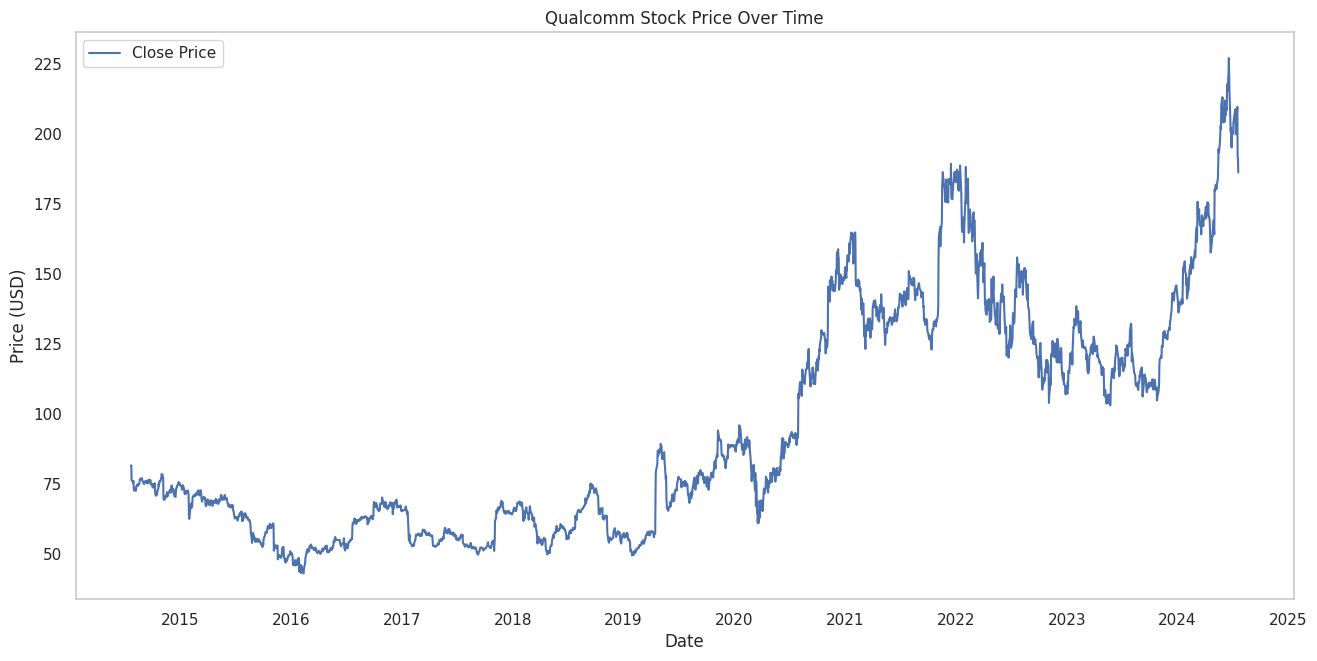

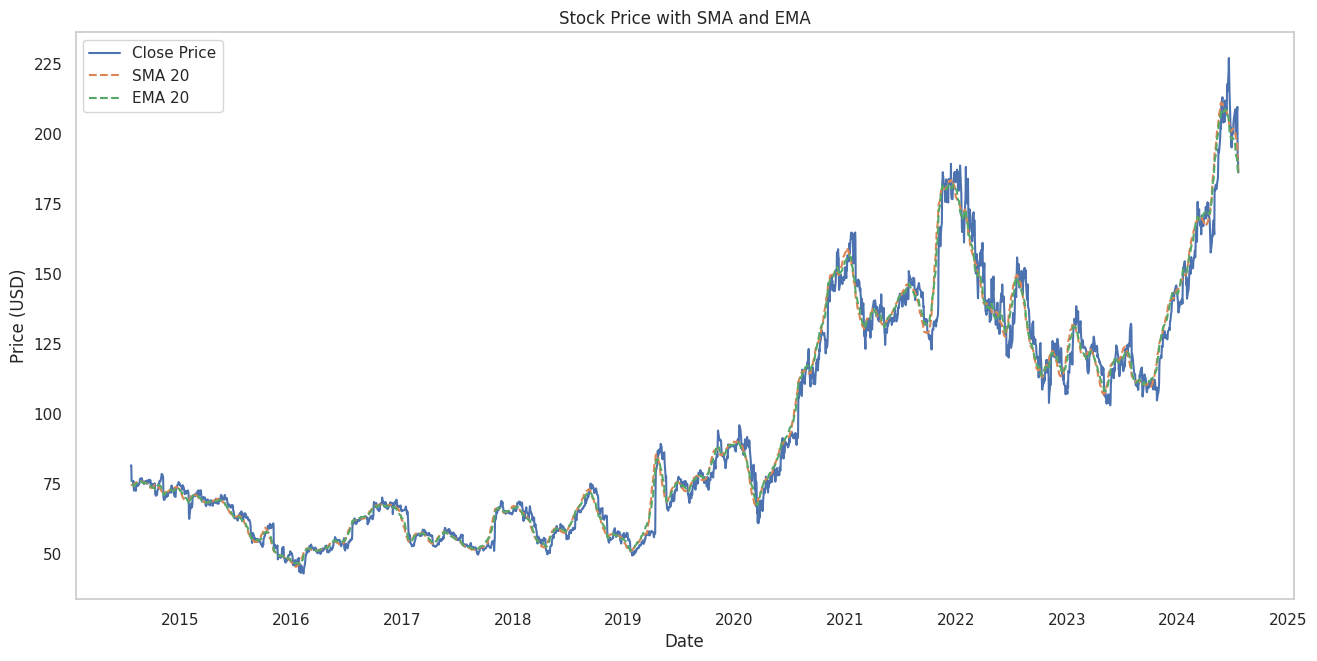

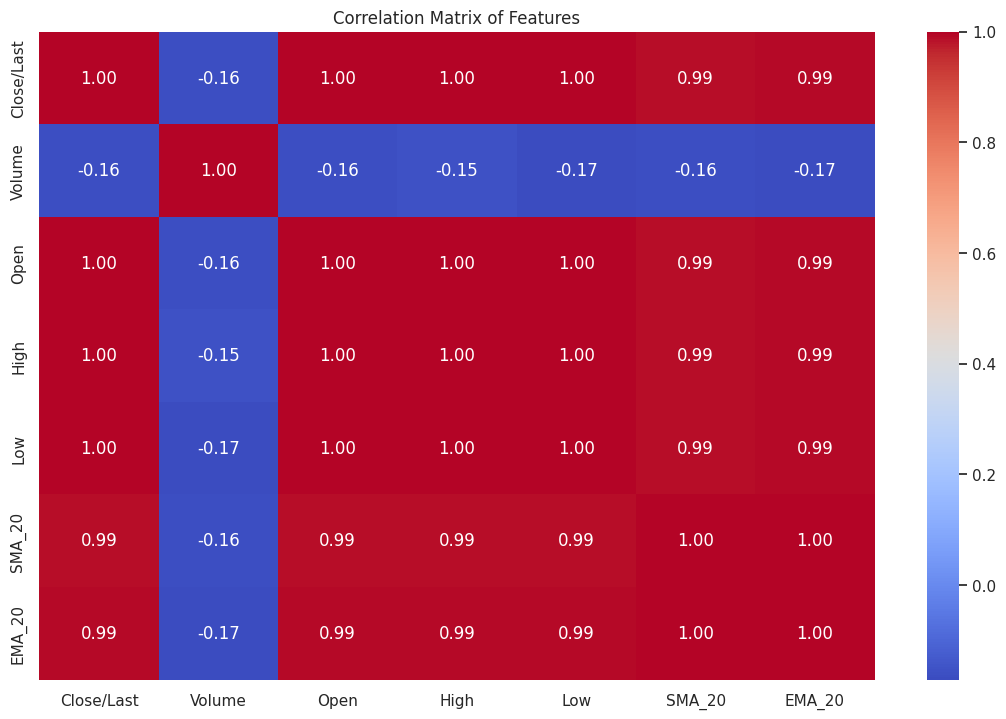

In [ ]:
# Descriptive statistics of the data
qualcomm_stock.describe()

# Visualizing the stock price over time
plt.figure(figsize=(14, 7))
plt.plot(qualcomm_stock['Close/Last'], label='Close Price')
plt.title('Qualcomm Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Plotting the stock price with SMA and EMA
qualcomm_stock['SMA_20'] = qualcomm_stock['Close/Last'].rolling(window=20, min_periods=1).mean()
qualcomm_stock['EMA_20'] = qualcomm_stock['Close/Last'].ewm(span=20, adjust=False).mean()

plt.figure(figsize=(14, 7))
plt.plot(qualcomm_stock['Close/Last'], label='Close Price')
plt.plot(qualcomm_stock['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(qualcomm_stock['EMA_20'], label='EMA 20', linestyle='--')
plt.title('Stock Price with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Correlation heatmap
features = ['Close/Last', 'Volume', 'Open', 'High', 'Low', 'SMA_20', 'EMA_20']
correlation_matrix = qualcomm_stock[features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()


Feature Engineering

In [ ]:
# Calculate additional technical indicators
delta = qualcomm_stock['Close/Last'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=14, min_periods=1).mean()
average_loss = loss.rolling(window=14, min_periods=1).mean()
rs = average_gain / average_loss
qualcomm_stock['RSI'] = 100 - (100 / (1 + rs))

ema_12 = qualcomm_stock['Close/Last'].ewm(span=12, adjust=False).mean()
ema_26 = qualcomm_stock['Close/Last'].ewm(span=26, adjust=False).mean()
qualcomm_stock['MACD'] = ema_12 - ema_26

qualcomm_stock['Upper_BB'] = qualcomm_stock['SMA_20'] + (2 * qualcomm_stock['Close/Last'].rolling(window=20).std())
qualcomm_stock['Lower_BB'] = qualcomm_stock['SMA_20'] - (2 * qualcomm_stock['Close/Last'].rolling(window=20).std())

# Select relevant features
features = ['Close/Last', 'Volume', 'Open', 'High', 'Low', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'Upper_BB', 'Lower_BB']

# Display the first few rows with new features
qualcomm_stock[features].head()


,Close/Last,Volume,Open,High,Low,SMA_20,EMA_20,RSI,MACD,Upper_BB,Lower_BB
Date,,,,,,,,,,,
2024-07-19,186.21,9195710,191.69,193.0888,185.7600,186.210000,186.210000,NaN,0.000000,NaN,NaN
2024-07-18,191.46,9960596,193.78,193.9000,186.9500,188.835000,186.710000,100.00000,0.418803,NaN,NaN
2024-07-17,191.60,16156210,199.73,200.0000,190.5600,189.756667,187.175714,100.00000,0.753321,NaN,NaN
2024-07-16,209.64,5998488,210.00,211.0900,206.6201,194.727500,189.315170,100.00000,2.445911,NaN,NaN
2024-07-15,208.18,7463726,203.00,209.2400,202.7850,197.418000,191.111821,94.13419,3.627674,NaN,NaN


Data Splitting and Normalization

In [ ]:
# Filling missing values
data = qualcomm_stock[features].copy()
data.fillna(method='bfill', inplace=True)

# Convert the dataframe to a numpy array
dataset = data.values

# Define the training data length (80% of the data)
training_data_len = int(np.ceil(len(dataset) * 0.8))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create train and test datasets
def create_dataset(data, time_step=60):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

# Creating training and test datasets
train_data = scaled_data[:training_data_len]
x_train, y_train = create_dataset(train_data)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

test_data = scaled_data[training_data_len - 60:]
x_test, y_test = create_dataset(test_data)
y_test_unscaled = dataset[training_data_len:, 0]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))


Model Development

In [ ]:
# Model Definitions

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=100))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# GRU Model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(GRU(units=100, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(GRU(units=100))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# CNN-LSTM Model
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=100))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


# Early Stopping to prevent overfitting
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


Model Training and Evaluation

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - loss: 0.0150 - mae: 0.0802
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - loss: 0.0027 - mae: 0.0377
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 0.0024 - mae: 0.0356
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - loss: 0.0030 - mae: 0.0396
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 0.0040 - mae: 0.0455
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - loss: 0.0022 - mae: 0.0343
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - loss: 0.0020 - mae: 0.0315
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0019 - mae: 0.0303
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - loss: 0.0030 - mae: 0.0396
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 0.0056 - mae: 0.0554
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - loss: 0.0018 - mae: 0.0300
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - loss: 0.0018 - mae: 0.0303
Ep

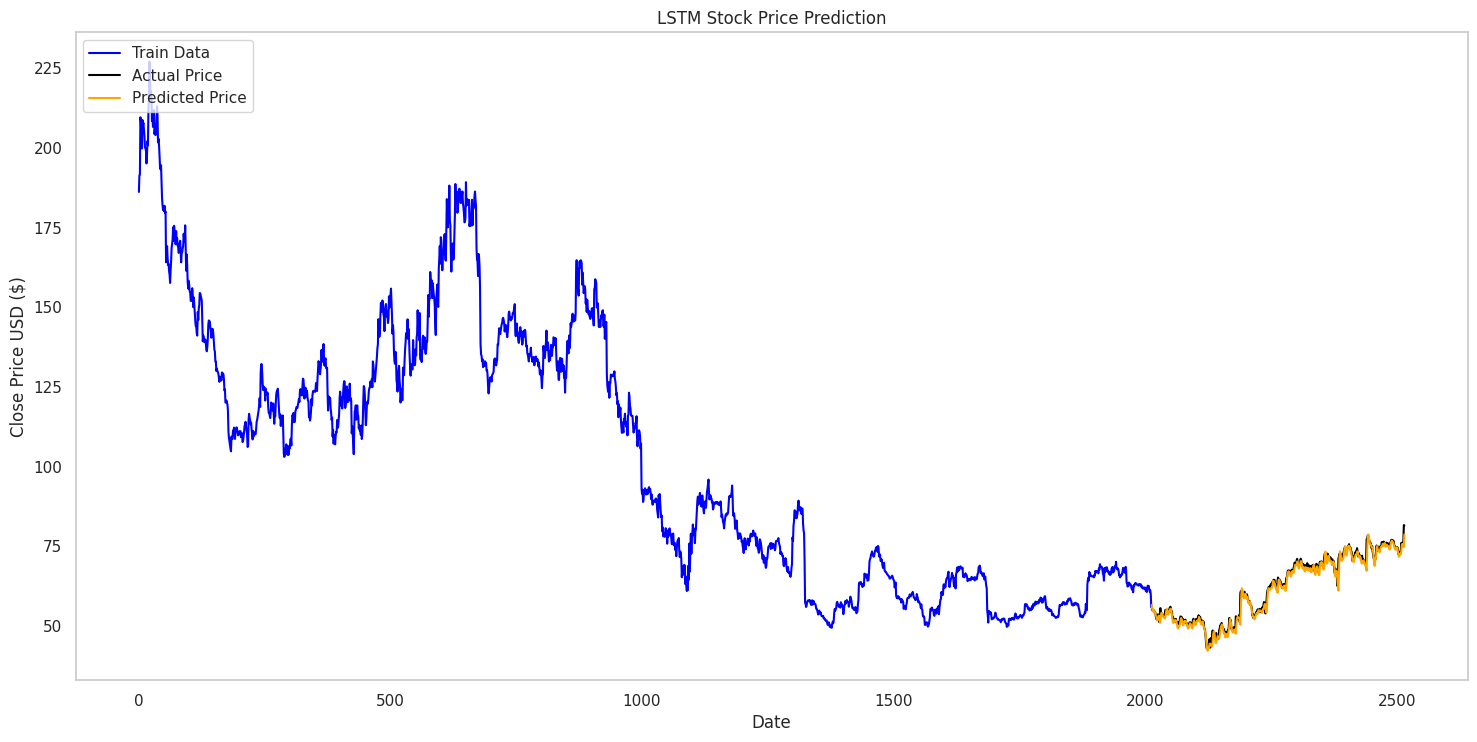

LSTM Model Accuracy: 98.41%


In [ ]:
# Function to evaluate the model
def evaluate_model(model, x_test, y_test_unscaled, scaler, title):
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(
        np.concatenate((predictions, np.zeros((predictions.shape[0], dataset.shape[1] - 1))), axis=1))[:, 0]

    rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions))
    mae = mean_absolute_error(y_test_unscaled, predictions)
    mape = mean_absolute_percentage_error(y_test_unscaled, predictions)
    r2 = r2_score(y_test_unscaled, predictions)

    print(f"{title} Model Performance:")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"R^2 Score: {r2}")

    plt.figure(figsize=(16, 8))
    plt.plot(dataset[:training_data_len, 0], label='Train Data', color='blue')
    plt.plot(range(training_data_len, len(dataset)), y_test_unscaled, label='Actual Price', color='black')
    plt.plot(range(training_data_len, len(dataset)), predictions, label='Predicted Price', color='orange')
    plt.legend(loc='upper left')
    plt.title(f'{title} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.grid()
    plt.show()

    return mape

# Function to calculate accuracy
def calculate_accuracy(mape):
    return 100 - (mape * 100)

# Train and evaluate models

input_shape = (x_train.shape[1], x_train.shape[2])

# LSTM Model
lstm_model = build_lstm_model(input_shape)
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)
lstm_mape = evaluate_model(lstm_model, x_test, y_test_unscaled, scaler, 'LSTM')
lstm_accuracy = calculate_accuracy(lstm_mape)
print(f"LSTM Model Accuracy: {lstm_accuracy:.2f}%")

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - loss: 0.0316 - mae: 0.1177
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0034 - mae: 0.0423
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - loss: 0.0029 - mae: 0.0382
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - loss: 0.0024 - mae: 0.0348
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - loss: 0.0024 - mae: 0.0340
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - loss: 0.0022 - mae: 0.0337
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - loss: 0.0020 - mae: 0.0321
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - loss: 0.0035 - mae: 0.0436
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - loss: 0.0023 - mae: 0.0343
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - loss: 0.0016 - mae: 0.0288
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
GRU Model Performance:
RMSE: 2.901874558160095
MAE: 2.516071450403953
MAPE: 0.0410015538521137
R^2 Score: 0.9160694915402293


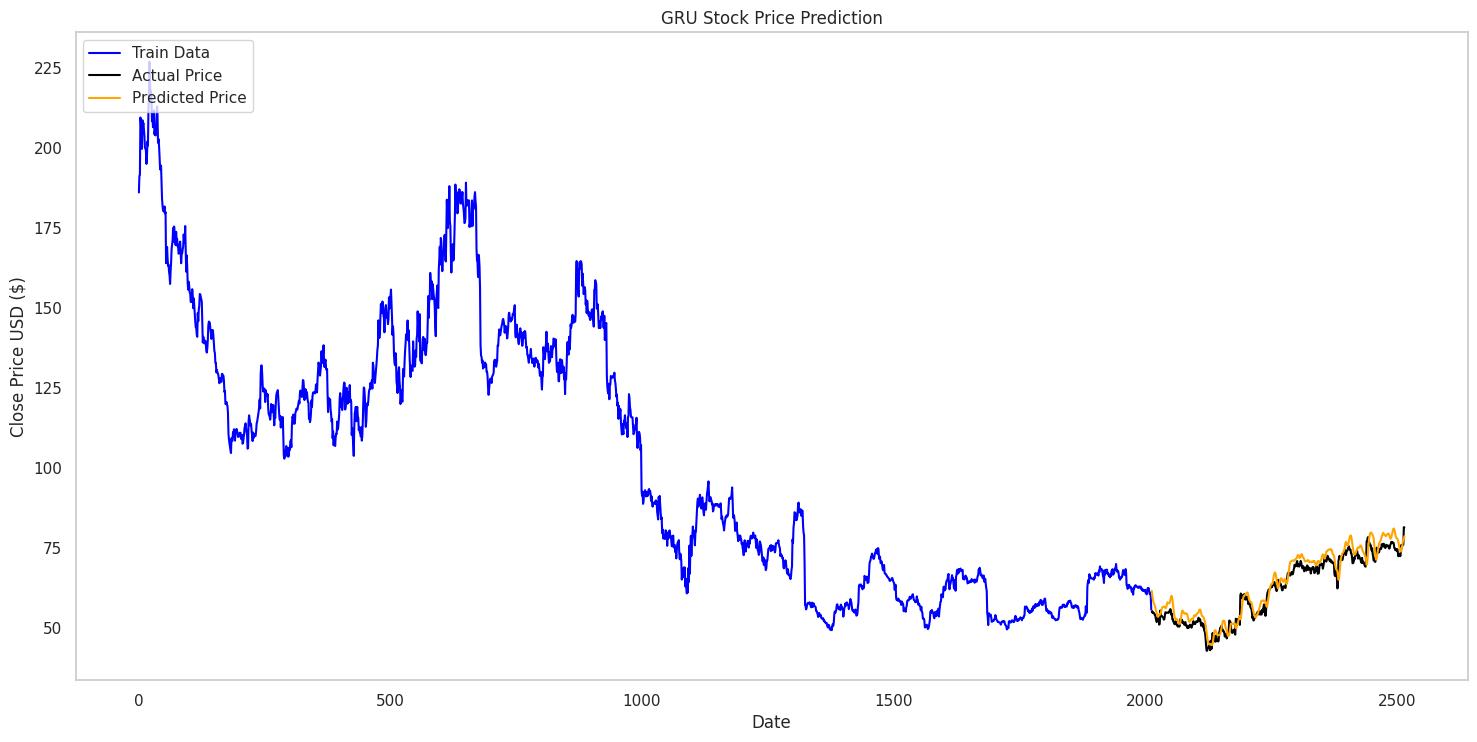

GRU Model Accuracy: 95.90%


In [ ]:
# GRU Model
gru_model = build_gru_model(input_shape)
gru_model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)
gru_mape = evaluate_model(gru_model, x_test, y_test_unscaled, scaler, 'GRU')
gru_accuracy = calculate_accuracy(gru_mape)
print(f"GRU Model Accuracy: {gru_accuracy:.2f}%")

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0197 - mae: 0.0949
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0040 - mae: 0.0453
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0028 - mae: 0.0394
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0027 - mae: 0.0368
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0047 - mae: 0.0489
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0025 - mae: 0.0358
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0021 - mae: 0.0328
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0023 - mae: 0.0342
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0025 - mae: 0.0356
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0022 - mae: 0.0336
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
CNN-LSTM Model Performance:
RMSE: 3.8517001588098254
MAE: 3.129516001636018
MAPE: 0.05077569813888123
R^2 Score: 0.8521342714891034


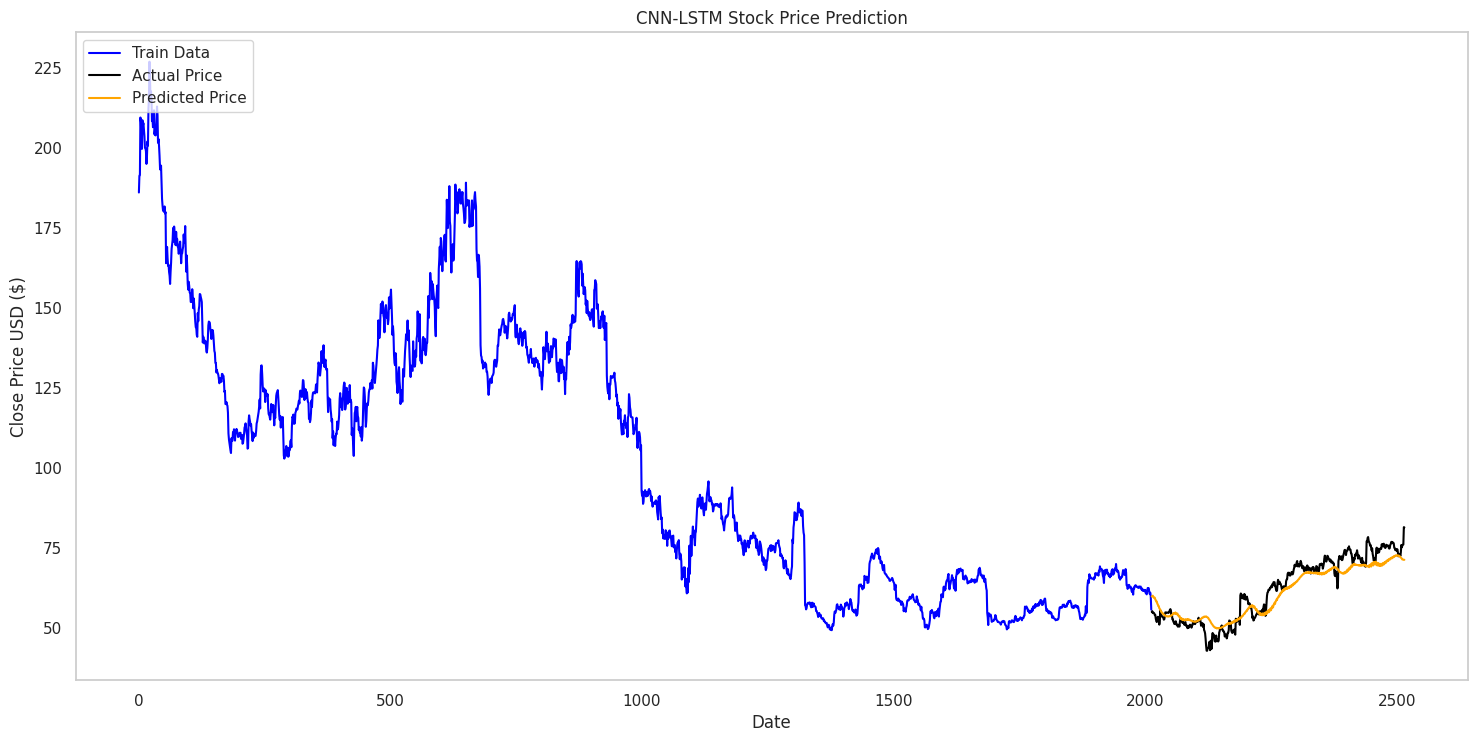

CNN-LSTM Model Accuracy: 94.92%


In [ ]:
# CNN-LSTM Model
cnn_lstm_model = build_cnn_lstm_model(input_shape)
cnn_lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)
cnn_lstm_mape = evaluate_model(cnn_lstm_model, x_test, y_test_unscaled, scaler, 'CNN-LSTM')
cnn_lstm_accuracy = calculate_accuracy(cnn_lstm_mape)
print(f"CNN-LSTM Model Accuracy: {cnn_lstm_accuracy:.2f}%")

In [ ]:
# Predict future prices
def predict_future_price(model, scaler, last_60_days, dataset):
    last_60_days_scaled = scaler.transform(last_60_days)
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(np.concatenate((pred_price, np.zeros((pred_price.shape[0], dataset.shape[1] - 1))), axis=1))[:, 0]
    return pred_price

last_60_days = dataset[-60:]
future_price_lstm = predict_future_price(lstm_model, scaler, last_60_days, dataset)
future_price_gru = predict_future_price(gru_model, scaler, last_60_days, dataset)
future_price_cnn_lstm = predict_future_price(cnn_lstm_model, scaler, last_60_days, dataset)

print(f'Future Price Prediction (LSTM): {future_price_lstm[0]}')
print(f'Future Price Prediction (GRU): {future_price_gru[0]}')
print(f'Future Price Prediction (CNN-LSTM): {future_price_cnn_lstm[0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Future Price Prediction (LSTM): 80.98158173322678
Future Price Prediction (GRU): 79.95032378479839
Future Price Prediction (CNN-LSTM): 71.48480990871788


## Conclusion

In this project, we explored the use of three different deep learning models—LSTM, GRU, and CNN-LSTM—for predicting Qualcomm stock prices. Each model was trained and evaluated using a set of performance metrics including RMSE, MAE, MAPE, R² Score, and Accuracy.

### Key Findings:

- **LSTM Model**: Achieved the highest accuracy of 98.41%, indicating it was the most effective model in predicting stock prices.
- **GRU Model**: Performed well, but with slightly lower accuracy compared to LSTM.
- **CNN-LSTM Model**: Provided the least accurate predictions among the three models.

### Future Work:

Future research could involve testing additional models or combining these models into an ensemble to potentially improve accuracy further. Additionally, exploring different feature sets could enhance predictive power.
